# 03 – NPU–Hour Burglary Modeling Notebook

Uses `npu_sparse_panel` from 01_wrangler to:
- Load panel data
- Define rolling-origin CV utilities
- Train multiple models (RF / XGB / CatBoost / Poisson + baselines)
- Log metrics & leaderboard to disk + Weights & Biases

--- Section 0: Imports, Paths, Data Load ---

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from rich.console import Console
from rich.table import Table
from rich.panel import Panel

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PoissonRegressor

# External ML libs (XGBoost / CatBoost)
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

try:
    from catboost import CatBoostRegressor
    HAS_CATBOOST = True
except ImportError:
    HAS_CATBOOST = False

# Weights & Biases (for experiment tracking)
try:
    import wandb
    HAS_WANDB = True
except ImportError:
    HAS_WANDB = False

console = Console()

### 0.1 Resolve project paths

In [2]:
# Robust project root detection (works in notebook or script)
try:
    ROOT = Path(__file__).resolve().parent.parent
except NameError:
    # In a notebook, __file__ is not defined; assume we're in /notebooks
    ROOT = Path.cwd().resolve().parent

DATA_DIR = Path("../data")
PROCESSED_DATA_FOLDER = DATA_DIR / "processed" / "apd"

# Test results + CV outputs (as requested)
TEST_RESULTS_DIR = ROOT / "reports" / "test_results"
CV_RESULTS_DIR = TEST_RESULTS_DIR / "cv_results"
CV_FOLDS_DIR = CV_RESULTS_DIR / "folds"
CV_PREDICTIONS_DIR = CV_RESULTS_DIR / "predictions"
WANDB_DIR = TEST_RESULTS_DIR / "wandb"

for d in [TEST_RESULTS_DIR, CV_RESULTS_DIR, CV_FOLDS_DIR, CV_PREDICTIONS_DIR, WANDB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Direct catboost logs into test_results instead of notebook dir
CATBOOST_TRAIN_DIR = TEST_RESULTS_DIR / "catboost_info"
CATBOOST_TRAIN_DIR.mkdir(parents=True, exist_ok=True)

# Point wandb to the correct directory
if HAS_WANDB:
    os.environ["WANDB_DIR"] = str(WANDB_DIR)

console.print(
    Panel.fit(
        f"[bold green]Paths configured[/bold green]\n"
        f"ROOT: {ROOT}\n"
        f"Processed: {PROCESSED_DATA_FOLDER}\n"
        f"Test results: {TEST_RESULTS_DIR}",
        border_style="green",
        title="Path Summary"
    )
)

╭───────────────────────────────── Path Summary ─────────────────────────────────╮
│ Paths configured                                                               │
│ ROOT: /workspaces/campus-burglary-risk-prediction                              │
│ Processed: ../data/processed/apd                                               │
│ Test results: /workspaces/campus-burglary-risk-prediction/reports/test_results │
╰────────────────────────────────────────────────────────────────────────────────╯

### 0.2 Load sparse NPU–hour panel

In [3]:
pipeline_log = []


def log_step(step_name: str, df: pd.DataFrame | None) -> None:
    """Simple pipeline logger for this notebook."""
    if df is None or not isinstance(df, pd.DataFrame) or df.empty:
        rows_val, cols_val = "N/A", "N/A"
    else:
        rows_val, cols_val = f"{len(df):,}", df.shape[1]

    pipeline_log.append({"step": step_name, "rows": rows_val, "cols": cols_val})

    console.print(
        f"[green]{step_name}[/green] → "
        f"[cyan]rows={rows_val}, cols={cols_val}[/cyan]"
    )


def show_pipeline_table() -> None:
    table = Table(title="Model T Pipeline Summary")
    table.add_column("Step", style="cyan")
    table.add_column("Rows", style="green", justify="right")
    table.add_column("Cols", style="yellow", justify="right")
    for entry in pipeline_log:
        table.add_row(entry["step"], str(entry["rows"]), str(entry["cols"]))
    console.print(table)


console.print(
    Panel(
        "[bold cyan]Loading sparse NPU–hour panel...[/bold cyan]",
        border_style="cyan",
    )
)

PANEL_PARQUET = PROCESSED_DATA_FOLDER / "npu_sparse_panel.parquet"
PANEL_CSV = PROCESSED_DATA_FOLDER / "npu_sparse_panel.csv"

if PANEL_PARQUET.exists():
    df = pd.read_parquet(PANEL_PARQUET)
elif PANEL_CSV.exists():
    df = pd.read_csv(PANEL_CSV)
else:
    raise FileNotFoundError(
        f"Could not find npu_sparse_panel at {PANEL_PARQUET} or {PANEL_CSV}"
    )

df["hour_ts"] = pd.to_datetime(df["hour_ts"])
df = df.sort_values(["hour_ts", "npu"]).reset_index(drop=True)

log_step("Step 0: Loaded sparse NPU–hour panel", df)

console.print(
    Panel.fit(
        f"[bold green]✓ Panel loaded successfully![/bold green]\n\n"
        f"Rows: [cyan]{len(df):,}[/cyan]\n"
        f"Columns: [cyan]{df.shape[1]}[/cyan]\n"
        f"Date range: [cyan]{df['hour_ts'].min()} to {df['hour_ts'].max()}[/cyan]\n"
        f"NPUs: [cyan]{df['npu'].nunique()}[/cyan]",
        border_style="green",
        title="Panel Summary",
    )
)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Loading sparse NPU–hour panel...                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Step 0: Loaded sparse NPU–hour panel → rows=100,497, cols=20

╭──────────────────── Panel Summary ─────────────────────╮
│ ✓ Panel loaded successfully!                           │
│                                                        │
│ Rows: 100,497                                          │
│ Columns: 20                                            │
│ Date range: 2021-01-01 05:00:00 to 2025-11-27 00:00:00 │
│ NPUs: 25                                               │
╰────────────────────────────────────────────────────────╯

### 0.3 Feature preparation

In [4]:
console.print(
    Panel(
        "[bold cyan]Preparing features (one-hot, numeric only)[/bold cyan]",
        border_style="cyan",
    )
)

# One-hot encode day_of_week if present
if "day_of_week" in df.columns:
    dow_dummies = pd.get_dummies(df["day_of_week"], prefix="dow", drop_first=True)
    df = pd.concat([df, dow_dummies], axis=1)

# Potential feature set from panel script
POTENTIAL_FEATURES = [
    "grid_density_7d",
    "npu_crime_avg_30d",
    "temp_f",
    "is_raining",
    "is_hot",
    "is_cold",
    "is_daylight",
    "is_weekend",
    "is_holiday",
    "day_number",
    "month",
    "year",
    "hour_sin",
    "hour_cos",
    "campus_distance_m",
    "location_type_count",
]

# Add any dow_ columns
POTENTIAL_FEATURES += [c for c in df.columns if c.startswith("dow_")]

FEATURE_COLS = [c for c in POTENTIAL_FEATURES if c in df.columns]

TARGET_COL = "burglary_count"
DATE_COL = "hour_ts"
GROUP_COL = "npu"

console.print(
    Panel.fit(
        f"[bold green]Features configured[/bold green]\n"
        f"Target: [cyan]{TARGET_COL}[/cyan]\n"
        f"Date: [cyan]{DATE_COL}[/cyan]\n"
        f"Group: [cyan]{GROUP_COL}[/cyan]\n"
        f"Num features: [cyan]{len(FEATURE_COLS)}[/cyan]",
        border_style="green",
        title="Modeling Config",
    )
)

from datetime import datetime

def time_since(ts):
    t = datetime.strptime(ts, "%Y-%m-%d %H:%M:%S")
    delta = datetime.now() - t
    mins = int(delta.total_seconds() // 60)
    if mins < 60:
        return f"{mins}m ago"
    hrs = mins // 60
    return f"{hrs}h ago"


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Preparing features (one-hot, numeric only)                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─── Modeling Config ────╮
│ Features configured    │
│ Target: burglary_count │
│ Date: hour_ts          │
│ Group: npu             │
│ Num features: 22       │
╰────────────────────────╯

--- Section 1: Rolling-Origin CV Utilities ---

In [5]:
console.print(
    Panel(
        "[bold magenta]STEP 1: Define modeling utilities for time-series cross-validation[/bold magenta]",
        border_style="magenta",
    )
)


def run_rolling_cv(
    model,
    df_in: pd.DataFrame,
    target_col: str = TARGET_COL,
    date_col: str = DATE_COL,
    feature_cols: list[str] | None = None,
    group_col: str = GROUP_COL,
    save_outputs: bool = True,
    model_name: str | None = None,
):
    """
    Rolling-origin CV on NPU–hour panel.

    Assumes df_in already contains aggregated target per (npu, hour_ts).
    If model has .fit, uses standard sklearn-style API.
    Otherwise expects: preds = model.predict(test_df, train_df)  (for baselines).
    """

    # ------------------ Model name normalization ------------------
    if model_name is None:
        model_name = model.__class__.__name__ if hasattr(model, "__class__") else str(model)
    model_name = model_name.replace(" ", "_").replace("(", "").replace(")", "")

    console.print(f"[cyan]Preparing data for rolling CV ({model_name})...[/cyan]")

    df_local = df_in.copy()
    df_local[date_col] = pd.to_datetime(df_local[date_col])

    # ------------------ CV folds ------------------
    folds = [
        ("2022-01-01", "2022-07-01"),  # Fold 1
        ("2022-07-01", "2023-01-01"),  # Fold 2
        ("2023-01-01", "2023-07-01"),  # Fold 3
        ("2023-07-01", "2024-01-01"),  # Fold 4
    ]

    results = []
    all_predictions = []

    console.print(f"[bold cyan]Starting Rolling CV for {model_name}...[/bold cyan]")

    for i, (train_end, test_end) in enumerate(folds):
        fold_num = i + 1
        fold_name = f"Fold {fold_num}"

        train_mask = df_local[date_col] < train_end
        test_mask = (df_local[date_col] >= train_end) & (df_local[date_col] < test_end)

        train_data = df_local[train_mask].copy()
        test_data = df_local[test_mask].copy()

        if len(test_data) == 0:
            console.print(f"[yellow]  {fold_name}: No test data, skipping.[/yellow]")
            continue

        # ------------------ Save splits ------------------
        if save_outputs:
            train_path = CV_FOLDS_DIR / f"{model_name}_fold{fold_num}_train.csv"
            test_path = CV_FOLDS_DIR / f"{model_name}_fold{fold_num}_test.csv"
            train_data.to_csv(train_path, index=False)
            test_data.to_csv(test_path, index=False)

        # ------------------ Feature detection (per fold) ------------------
        if feature_cols is None:
            drop_cols = [target_col, date_col, group_col, "geometry"]
            drop_cols = [c for c in drop_cols if c in train_data.columns]
            local_feature_cols = [c for c in train_data.columns if c not in drop_cols]
        else:
            local_feature_cols = list(feature_cols)

        X_train = train_data[local_feature_cols]
        y_train = train_data[target_col]
        X_test = test_data[local_feature_cols]
        y_test = test_data[target_col]

        # ------------------ Fit & predict ------------------
        if hasattr(model, "fit"):
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
        else:
            # For custom baselines that don't implement .fit
            preds = model.predict(test_data, train_data)

        # ------------------ Metrics ------------------
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)
        mape = np.mean(np.abs((y_test - preds) / (y_test + 1e-10))) * 100

        console.print(
            f"[green]  {fold_name} ({train_end} → {test_end}):[/green] "
            f"MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}, MAPE={mape:.2f}%"
        )

        results.append(
            {
                "Model": model_name,
                "Fold": fold_name,
                "Fold_Number": fold_num,
                "Train_End": train_end,
                "Test_End": test_end,
                "Train_Size": len(train_data),
                "Test_Size": len(test_data),
                "MAE": mae,
                "RMSE": rmse,
                "R²": r2,
                "MAPE": mape,
            }
        )

        pred_df = test_data[[date_col, group_col, target_col]].copy()
        pred_df["predicted"] = preds
        pred_df["residual"] = y_test.values - preds
        pred_df["abs_error"] = np.abs(pred_df["residual"])
        pred_df["fold"] = fold_name
        pred_df["fold_number"] = fold_num
        all_predictions.append(pred_df)

    metrics_df = pd.DataFrame(results)
    predictions_df = (
        pd.concat(all_predictions, ignore_index=True) if all_predictions else pd.DataFrame()
    )

    # ------------------ Save summary ------------------
    if save_outputs and len(metrics_df) > 0:
        metrics_path = CV_RESULTS_DIR / f"{model_name}_cv_metrics.csv"
        metrics_df.to_csv(metrics_path, index=False)

        if len(predictions_df) > 0:
            predictions_path = CV_PREDICTIONS_DIR / f"{model_name}_all_predictions.csv"
            predictions_df.to_csv(predictions_path, index=False)

    # ------------------ Rich summary table ------------------
    console.print("\n[bold green]Cross-Validation Summary:[/bold green]")
    if len(metrics_df) > 0:
        summary_table = Table(title=f"{model_name} - CV Performance", show_header=True)
        summary_table.add_column("Metric")
        summary_table.add_column("Mean")
        summary_table.add_column("Std")
        summary_table.add_column("Min")
        summary_table.add_column("Max")

        for metric in ["MAE", "RMSE", "R²", "MAPE"]:
            summary_table.add_row(
                metric,
                f"{metrics_df[metric].mean():.4f}",
                f"±{metrics_df[metric].std():.4f}",
                f"{metrics_df[metric].min():.4f}",
                f"{metrics_df[metric].max():.4f}",
            )

        console.print(summary_table)
    else:
        console.print("[yellow]No folds produced metrics.[/yellow]")

    return metrics_df, predictions_df


log_step("Step 1: Modeling utilities with auto-save functionality", None)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 1: Define modeling utilities for time-series cross-validation                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Step 1: Modeling utilities with auto-save functionality → rows=N/A, cols=N/A

--- Section 2: Baseline & Model Zoo Definitions ---

In [6]:
console.print(
    Panel(
        "[bold magenta]STEP 2: Define baselines and model zoo[/bold magenta]",
        border_style="magenta",
    )
)

# --- Simple baseline models (no .fit) ---------------------------------------
class NaiveMeanModel:
    """Predicts global mean of target from training set."""

    def predict(self, test_df: pd.DataFrame, train_df: pd.DataFrame):
        mean_val = train_df[TARGET_COL].mean()
        return np.full(shape=len(test_df), fill_value=mean_val)


class NaiveLastHourModel:
    """
    For each (npu, hour_ts) in test:
    predict last observed value for that NPU (or global mean if none).
    """

    def predict(self, test_df: pd.DataFrame, train_df: pd.DataFrame):
        # Build lookup from train
        train_sorted = train_df.sort_values(DATE_COL)
        last_vals = (
            train_sorted.groupby(GROUP_COL)[TARGET_COL].last().to_dict()
        )
        global_mean = train_sorted[TARGET_COL].mean()

        preds = []
        for _, row in test_df.iterrows():
            npu = row[GROUP_COL]
            preds.append(last_vals.get(npu, global_mean))
        return np.array(preds)


class SeasonalWeeklyMeanModel:
    """
    Seasonal weekly: mean per (NPU, hour-of-week) from training.
    hour_of_week = day_number * 24 + hour_of_day (approx, using day_number).
    """

    def predict(self, test_df: pd.DataFrame, train_df: pd.DataFrame):
        # Ensure day_number + hour exist
        tr = train_df.copy()
        ts = test_df.copy()

        if "day_number" not in tr.columns:
            tr["day_number"] = pd.to_datetime(tr[DATE_COL]).dt.weekday + 1
        if "day_number" not in ts.columns:
            ts["day_number"] = pd.to_datetime(ts[DATE_COL]).dt.weekday + 1

        tr["hour"] = pd.to_datetime(tr[DATE_COL]).dt.hour
        ts["hour"] = pd.to_datetime(ts[DATE_COL]).dt.hour

        tr["hour_of_week"] = (tr["day_number"] - 1) * 24 + tr["hour"]
        ts["hour_of_week"] = (ts["day_number"] - 1) * 24 + ts["hour"]

        key_cols = [GROUP_COL, "hour_of_week"]

        mean_lookup = (
            tr.groupby(key_cols)[TARGET_COL].mean().reset_index().set_index(key_cols)
        )

        global_mean = tr[TARGET_COL].mean()
        preds = []
        for _, row in ts.iterrows():
            key = (row[GROUP_COL], row["hour_of_week"])
            preds.append(mean_lookup[TARGET_COL].get(key, global_mean))

        return np.array(preds)


# --- Tree / GLM models ------------------------------------------------------
MODEL_ZOO: dict[str, object] = {}

# Baselines
MODEL_ZOO["NaiveMean"] = NaiveMeanModel()
MODEL_ZOO["NaiveLastHour"] = NaiveLastHourModel()
MODEL_ZOO["SeasonalWeekly"] = SeasonalWeeklyMeanModel()

# Random Forest
MODEL_ZOO["RandomForest"] = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
)

# XGBoost (if available)
if HAS_XGB:
    MODEL_ZOO["XGBRegressor"] = XGBRegressor(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1,
        tree_method="hist",
        random_state=42,
    )
else:
    console.print("[yellow]XGBoost not installed; skipping XGBRegressor.[/yellow]")

# CatBoost (if available)
if HAS_CATBOOST:
    MODEL_ZOO["CatBoost"] = CatBoostRegressor(
        depth=6,
        learning_rate=0.05,
        iterations=400,
        loss_function="RMSE",
        random_seed=42,
        verbose=False,
        train_dir=str(CATBOOST_TRAIN_DIR),
    )
else:
    console.print("[yellow]CatBoost not installed; skipping CatBoost.[/yellow]")

# Poisson GLM (sklearn)
MODEL_ZOO["PoissonGLM"] = PoissonRegressor(alpha=0.0, max_iter=1000)

console.print(
    Panel.fit(
        "[bold green]Model zoo initialized:[/bold green]\n"
        + "\n".join(f" • {name}" for name in MODEL_ZOO.keys()),
        border_style="green",
        title="Models",
    )
)

log_step("Step 2: Model zoo defined", None)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 2: Define baselines and model zoo                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────── Models ────────╮
│ Model zoo initialized: │
│  • NaiveMean           │
│  • NaiveLastHour       │
│  • SeasonalWeekly      │
│  • RandomForest        │
│  • XGBRegressor        │
│  • CatBoost            │
│  • PoissonGLM          │
╰────────────────────────╯

Step 2: Model zoo defined → rows=N/A, cols=N/A

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 3.3: Running rolling CV for all models in MODEL_ZOO                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

wandb: Currently logged in as: joshuadariuspina (joshuadariuspina-georgia-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Running rolling CV for model: NaiveMean                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Preparing data for rolling CV (NaiveMean)...

Starting Rolling CV for NaiveMean...

  Fold 1 (2022-01-01 → 2022-07-01): MAE=0.2327, RMSE=0.3829, R²=-0.0018, MAPE=17.33%

  Fold 2 (2022-07-01 → 2023-01-01): MAE=0.2389, RMSE=0.4244, R²=-0.0000, MAPE=17.11%

  Fold 3 (2023-01-01 → 2023-07-01): MAE=0.2436, RMSE=0.4348, R²=-0.0002, MAPE=17.31%

  Fold 4 (2023-07-01 → 2024-01-01): MAE=0.2325, RMSE=0.3996, R²=-0.0006, MAPE=17.04%

Cross-Validation Summary:

            NaiveMean - CV Performance            
┏━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric ┃ Mean    ┃ Std     ┃ Min     ┃ Max     ┃
┡━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ MAE    │ 0.2369  │ ±0.0053 │ 0.2325  │ 0.2436  │
│ RMSE   │ 0.4104  │ ±0.0236 │ 0.3829  │ 0.4348  │
│ R²     │ -0.0007 │ ±0.0008 │ -0.0018 │ -0.0000 │
│ MAPE   │ 17.1993 │ ±0.1444 │ 17.0401 │ 17.3341 │
└────────┴─────────┴─────────┴─────────┴─────────┘

Mean_MAE,▁
Mean_MAPE,▁
Mean_R2,▁
Mean_RMSE,▁
Mean_MAE,0.23691
Mean_MAPE,17.19934
Mean_R2,-0.00065
Mean_RMSE,0.41042
Model,NaiveMean
Timestamp,2025-12-02 13:52:10


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Running rolling CV for model: NaiveLastHour                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Preparing data for rolling CV (NaiveLastHour)...

Starting Rolling CV for NaiveLastHour...

  Fold 1 (2022-01-01 → 2022-07-01): MAE=0.1717, RMSE=0.4578, R²=-0.4320, MAPE=10.56%

  Fold 2 (2022-07-01 → 2023-01-01): MAE=0.1346, RMSE=0.4452, R²=-0.1006, MAPE=5.89%

  Fold 3 (2023-01-01 → 2023-07-01): MAE=0.1409, RMSE=0.4570, R²=-0.1050, MAPE=6.20%

  Fold 4 (2023-07-01 → 2024-01-01): MAE=0.1957, RMSE=0.4947, R²=-0.5342, MAPE=12.80%

Cross-Validation Summary:

          NaiveLastHour - CV Performance          
┏━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric ┃ Mean    ┃ Std     ┃ Min     ┃ Max     ┃
┡━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ MAE    │ 0.1607  │ ±0.0284 │ 0.1346  │ 0.1957  │
│ RMSE   │ 0.4637  │ ±0.0215 │ 0.4452  │ 0.4947  │
│ R²     │ -0.2929 │ ±0.2235 │ -0.5342 │ -0.1006 │
│ MAPE   │ 8.8640  │ ±3.3794 │ 5.8924  │ 12.7989 │
└────────┴─────────┴─────────┴─────────┴─────────┘

Mean_MAE,▁
Mean_MAPE,▁
Mean_R2,▁
Mean_RMSE,▁
Mean_MAE,0.16071
Mean_MAPE,8.86399
Mean_R2,-0.29293
Mean_RMSE,0.4637
Model,NaiveLastHour
Timestamp,2025-12-02 13:52:18


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Running rolling CV for model: SeasonalWeekly                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Preparing data for rolling CV (SeasonalWeekly)...

Starting Rolling CV for SeasonalWeekly...

  Fold 1 (2022-01-01 → 2022-07-01): MAE=0.2187, RMSE=0.3984, R²=-0.0845, MAPE=16.33%

  Fold 2 (2022-07-01 → 2023-01-01): MAE=0.2203, RMSE=0.4247, R²=-0.0013, MAPE=15.65%

  Fold 3 (2023-01-01 → 2023-07-01): MAE=0.2218, RMSE=0.4281, R²=0.0306, MAPE=15.62%

  Fold 4 (2023-07-01 → 2024-01-01): MAE=0.2132, RMSE=0.3932, R²=0.0308, MAPE=15.58%

Cross-Validation Summary:

         SeasonalWeekly - CV Performance          
┏━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric ┃ Mean    ┃ Std     ┃ Min     ┃ Max     ┃
┡━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ MAE    │ 0.2185  │ ±0.0038 │ 0.2132  │ 0.2218  │
│ RMSE   │ 0.4111  │ ±0.0178 │ 0.3932  │ 0.4281  │
│ R²     │ -0.0061 │ ±0.0544 │ -0.0845 │ 0.0308  │
│ MAPE   │ 15.7929 │ ±0.3606 │ 15.5756 │ 16.3321 │
└────────┴─────────┴─────────┴─────────┴─────────┘

Mean_MAE,▁
Mean_MAPE,▁
Mean_R2,▁
Mean_RMSE,▁
Mean_MAE,0.2185
Mean_MAPE,15.7929
Mean_R2,-0.00609
Mean_RMSE,0.4111
Model,SeasonalWeekly
Timestamp,2025-12-02 13:52:27


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Running rolling CV for model: RandomForest                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Preparing data for rolling CV (RandomForest)...

Starting Rolling CV for RandomForest...

  Fold 1 (2022-01-01 → 2022-07-01): MAE=0.0770, RMSE=0.2157, R²=0.6821, MAPE=5.56%

  Fold 2 (2022-07-01 → 2023-01-01): MAE=0.0815, RMSE=0.2414, R²=0.6763, MAPE=5.84%

  Fold 3 (2023-01-01 → 2023-07-01): MAE=0.0671, RMSE=0.2267, R²=0.7282, MAPE=4.45%

  Fold 4 (2023-07-01 → 2024-01-01): MAE=0.0764, RMSE=0.1998, R²=0.7498, MAPE=5.74%

Cross-Validation Summary:

         RandomForest - CV Performance         
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ Metric ┃ Mean   ┃ Std     ┃ Min    ┃ Max    ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ MAE    │ 0.0755 │ ±0.0060 │ 0.0671 │ 0.0815 │
│ RMSE   │ 0.2209 │ ±0.0176 │ 0.1998 │ 0.2414 │
│ R²     │ 0.7091 │ ±0.0357 │ 0.6763 │ 0.7498 │
│ MAPE   │ 5.3982 │ ±0.6425 │ 4.4498 │ 5.8368 │
└────────┴────────┴─────────┴────────┴────────┘

Mean_MAE,▁
Mean_MAPE,▁
Mean_R2,▁
Mean_RMSE,▁
Mean_MAE,0.07552
Mean_MAPE,5.3982
Mean_R2,0.70911
Mean_RMSE,0.2209
Model,RandomForest
Timestamp,2025-12-02 13:54:36


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Running rolling CV for model: XGBRegressor                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Preparing data for rolling CV (XGBRegressor)...

Starting Rolling CV for XGBRegressor...

  Fold 1 (2022-01-01 → 2022-07-01): MAE=0.0787, RMSE=0.2049, R²=0.7130, MAPE=5.44%

  Fold 2 (2022-07-01 → 2023-01-01): MAE=0.0872, RMSE=0.2422, R²=0.6743, MAPE=5.94%

  Fold 3 (2023-01-01 → 2023-07-01): MAE=0.0753, RMSE=0.2354, R²=0.7068, MAPE=4.75%

  Fold 4 (2023-07-01 → 2024-01-01): MAE=0.0802, RMSE=0.2030, R²=0.7416, MAPE=5.74%

Cross-Validation Summary:

         XGBRegressor - CV Performance         
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ Metric ┃ Mean   ┃ Std     ┃ Min    ┃ Max    ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ MAE    │ 0.0804 │ ±0.0050 │ 0.0753 │ 0.0872 │
│ RMSE   │ 0.2214 │ ±0.0203 │ 0.2030 │ 0.2422 │
│ R²     │ 0.7089 │ ±0.0276 │ 0.6743 │ 0.7416 │
│ MAPE   │ 5.4688 │ ±0.5246 │ 4.7454 │ 5.9441 │
└────────┴────────┴─────────┴────────┴────────┘

Mean_MAE,▁
Mean_MAPE,▁
Mean_R2,▁
Mean_RMSE,▁
Mean_MAE,0.08036
Mean_MAPE,5.46878
Mean_R2,0.70893
Mean_RMSE,0.2214
Model,XGBRegressor
Timestamp,2025-12-02 13:54:46


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Running rolling CV for model: CatBoost                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Preparing data for rolling CV (CatBoost)...

Starting Rolling CV for CatBoost...

  Fold 1 (2022-01-01 → 2022-07-01): MAE=0.0700, RMSE=0.1922, R²=0.7477, MAPE=4.80%

  Fold 2 (2022-07-01 → 2023-01-01): MAE=0.0759, RMSE=0.2199, R²=0.7315, MAPE=5.07%

  Fold 3 (2023-01-01 → 2023-07-01): MAE=0.0705, RMSE=0.2188, R²=0.7467, MAPE=4.45%

  Fold 4 (2023-07-01 → 2024-01-01): MAE=0.0733, RMSE=0.1923, R²=0.7682, MAPE=5.11%

Cross-Validation Summary:

           CatBoost - CV Performance           
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ Metric ┃ Mean   ┃ Std     ┃ Min    ┃ Max    ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ MAE    │ 0.0724 │ ±0.0027 │ 0.0700 │ 0.0759 │
│ RMSE   │ 0.2058 │ ±0.0157 │ 0.1922 │ 0.2199 │
│ R²     │ 0.7486 │ ±0.0151 │ 0.7315 │ 0.7682 │
│ MAPE   │ 4.8577 │ ±0.3066 │ 4.4493 │ 5.1139 │
└────────┴────────┴─────────┴────────┴────────┘

Mean_MAE,▁
Mean_MAPE,▁
Mean_R2,▁
Mean_RMSE,▁
Mean_MAE,0.07243
Mean_MAPE,4.85765
Mean_R2,0.74856
Mean_RMSE,0.20579
Model,CatBoost
Timestamp,2025-12-02 13:55:01


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Running rolling CV for model: PoissonGLM                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Preparing data for rolling CV (PoissonGLM)...

Starting Rolling CV for PoissonGLM...

/workspaces/campus-burglary-risk-prediction/dsci_env/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:286: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result(


  Fold 1 (2022-01-01 → 2022-07-01): MAE=0.2109, RMSE=0.3747, R²=0.0409, MAPE=15.37%

/workspaces/campus-burglary-risk-prediction/dsci_env/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:286: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result(


  Fold 2 (2022-07-01 → 2023-01-01): MAE=0.2331, RMSE=0.4139, R²=0.0489, MAPE=16.96%

/workspaces/campus-burglary-risk-prediction/dsci_env/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:286: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result(


  Fold 3 (2023-01-01 → 2023-07-01): MAE=0.2183, RMSE=0.4232, R²=0.0526, MAPE=15.03%

/workspaces/campus-burglary-risk-prediction/dsci_env/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:286: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result(


  Fold 4 (2023-07-01 → 2024-01-01): MAE=0.2171, RMSE=0.3863, R²=0.0645, MAPE=15.87%

Cross-Validation Summary:

           PoissonGLM - CV Performance            
┏━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric ┃ Mean    ┃ Std     ┃ Min     ┃ Max     ┃
┡━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ MAE    │ 0.2198  │ ±0.0094 │ 0.2109  │ 0.2331  │
│ RMSE   │ 0.3995  │ ±0.0228 │ 0.3747  │ 0.4232  │
│ R²     │ 0.0517  │ ±0.0098 │ 0.0409  │ 0.0645  │
│ MAPE   │ 15.8087 │ ±0.8415 │ 15.0318 │ 16.9601 │
└────────┴─────────┴─────────┴─────────┴─────────┘

Mean_MAE,▁
Mean_MAPE,▁
Mean_R2,▁
Mean_RMSE,▁
Mean_MAE,0.21983
Mean_MAPE,15.80871
Mean_R2,0.05173
Mean_RMSE,0.39952
Model,PoissonGLM
Timestamp,2025-12-02 13:55:28


Model Leaderboard (lower MAE is better):

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model          ┃ Mean MAE ┃ Mean RMSE ┃ Mean R² ┃ Mean MAPE (%) ┃           Timestamp ┃       Ago ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ CatBoost       │   0.0724 │    0.2058 │  0.7486 │          4.86 │ 2025-12-02 13:55:01 │ 0 min ago │
│ RandomForest   │   0.0755 │    0.2209 │  0.7091 │          5.40 │ 2025-12-02 13:54:36 │ 1 min ago │
│ XGBRegressor   │   0.0804 │    0.2214 │  0.7089 │          5.47 │ 2025-12-02 13:54:46 │ 1 min ago │
│ NaiveLastHour  │   0.1607 │    0.4637 │ -0.2929 │          8.86 │ 2025-12-02 13:52:18 │ 3 min ago │
│ SeasonalWeekly │   0.2185 │    0.4111 │ -0.0061 │         15.79 │ 2025-12-02 13:52:27 │ 3 min ago │
│ PoissonGLM     │   0.2198 │    0.3995 │  0.0517 │         15.81 │ 2025-12-02 13:55:28 │ 0 min ago │
│ NaiveMean      │   0.2369 │    0.4104 │ -0.0007 │         17.20 │ 2025-12-02 13:52:10 │ 3 min ago │
└────────────────┴──────────┴───────────┴─────────┴───────────────┴─────────────────────┴───────────┘

/tmp/ipykernel_36372/4071530484.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_leaderboard, x="Mean_RMSE", y="Model", ax=axes[0], palette="magma")
/tmp/ipykernel_36372/4071530484.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_leaderboard, x="Mean_R2", y="Model", ax=axes[1], palette="cool")


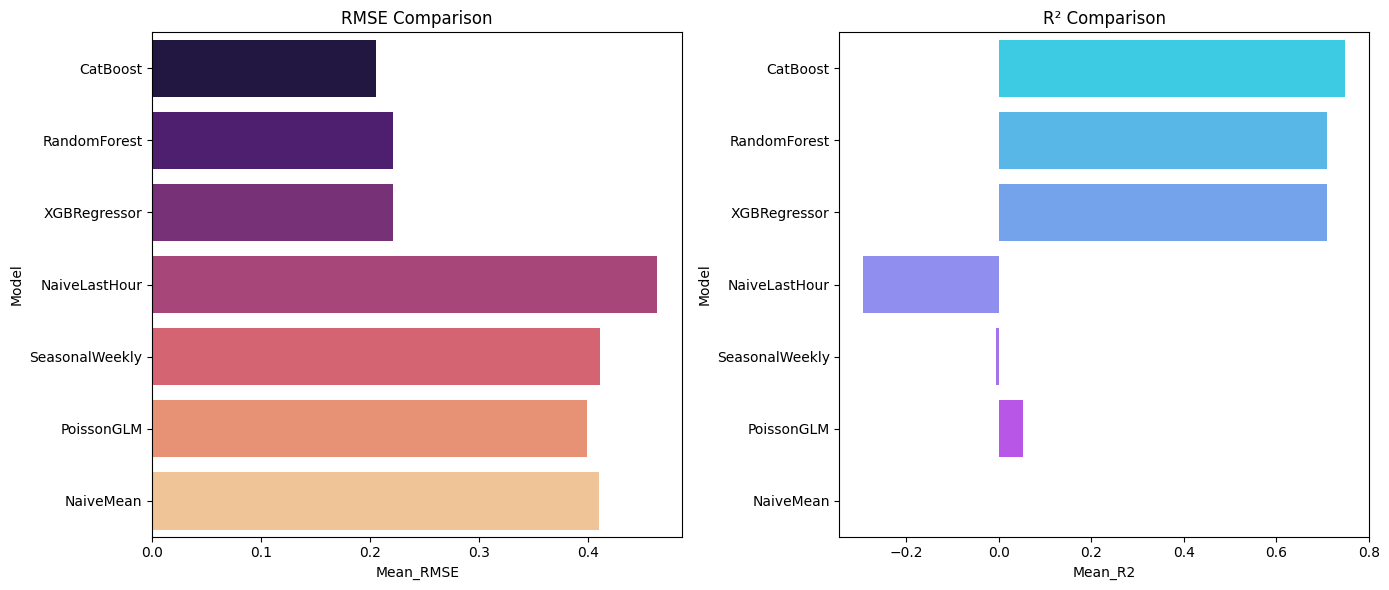

✓ Leaderboard updated → 
/workspaces/campus-burglary-risk-prediction/reports/test_results/cv_results/model_leaderboard_summary.csv

Step 3.3: Rolling CV (single pass) → rows=N/A, cols=N/A

In [7]:
# --- Section 3.3: Rolling Cross-Validation (single pass) ---

console.print(
    Panel(
        "[bold magenta]STEP 3.3: Running rolling CV for all models in MODEL_ZOO[/bold magenta]",
        border_style="magenta",
    )
)

# --- W&B Project/Entity ---
WANDB_PROJECT = "rolling-cv"
WANDB_ENTITY = "joshuadariuspina-georgia-state-university"

# Helper to compute “ago” for leaderboard
def time_since(ts):
    ts = pd.to_datetime(ts)
    delta = pd.Timestamp.now() - ts
    hours = delta.total_seconds() / 3600
    if hours < 1:
        return f"{round(hours*60)} min ago"
    elif hours < 24:
        return f"{round(hours)} hours ago"
    else:
        return f"{round(hours/24)} days ago"


# --- Close any previously open W&B run (safely) ---
if HAS_WANDB:
    try:
        wandb.finish()
    except:
        pass

all_cv_metrics: list[pd.DataFrame] = []
model_summary_rows: list[dict] = []


# ======================================================
#   LOOP THROUGH MODELS (ONE TIME ONLY)
# ======================================================
for model_name, model in MODEL_ZOO.items():

    # 1. W&B Run
    if HAS_WANDB:
        run = wandb.init(
            project=WANDB_PROJECT,
            entity=WANDB_ENTITY,
            name=f"{model_name}_rolling_cv",
            config={
                "model": model_name,
                "group": "rolling_cv",
                "features": FEATURE_COLS,
            },
            reinit=True,
        )
    else:
        run = None

    console.print(
        Panel(
            f"[bold cyan]Running rolling CV for model:[/bold cyan] [yellow]{model_name}[/yellow]",
            border_style="cyan",
        )
    )

    # 2. Run Rolling CV (df_in=df!)
    metrics_df, preds_df = run_rolling_cv(
        model=model,
        df_in=df,
        target_col=TARGET_COL,
        date_col=DATE_COL,
        feature_cols=FEATURE_COLS,
        group_col=GROUP_COL,
        save_outputs=True,
        model_name=model_name,
    )

    if metrics_df is None or metrics_df.empty:
        console.print(f"[red]No metrics for {model_name}, skipping.[/red]")
        if run is not None:
            run.finish()
        continue

    all_cv_metrics.append(metrics_df)

    # 3. Summary Aggregation
    summary_row = {
        "Model": model_name,
        "Mean_MAE": metrics_df["MAE"].mean(),
        "Mean_RMSE": metrics_df["RMSE"].mean(),
        "Mean_R2": metrics_df["R²"].mean(),
        "Mean_MAPE": metrics_df["MAPE"].mean(),
        "Timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
    }
    model_summary_rows.append(summary_row)

    # 4. Log to W&B
    if run is not None:
        wandb.log(summary_row)
        run.finish()


# ======================================================
# 5. Leaderboard
# ======================================================
if model_summary_rows:

    model_leaderboard = pd.DataFrame(model_summary_rows)
    model_leaderboard = model_leaderboard.sort_values("Mean_MAE")

    console.print("\n[bold green]Model Leaderboard (lower MAE is better):[/bold green]")

    leaderboard_table = Table(show_header=True, header_style="bold magenta")
    leaderboard_table.add_column("Model", style="cyan")
    leaderboard_table.add_column("Mean MAE", justify="right")
    leaderboard_table.add_column("Mean RMSE", justify="right")
    leaderboard_table.add_column("Mean R²", justify="right")
    leaderboard_table.add_column("Mean MAPE (%)", justify="right")
    leaderboard_table.add_column("Timestamp", justify="right", style="dim")
    leaderboard_table.add_column("Ago", justify="right", style="blue")

    for _, row in model_leaderboard.iterrows():
        leaderboard_table.add_row(
            row["Model"],
            f"{row['Mean_MAE']:.4f}",
            f"{row['Mean_RMSE']:.4f}",
            f"{row['Mean_R2']:.4f}",
            f"{row['Mean_MAPE']:.2f}",
            row["Timestamp"],
            time_since(row["Timestamp"]),
        )

    console.print(leaderboard_table)

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.barplot(data=model_leaderboard, x="Mean_RMSE", y="Model", ax=axes[0], palette="magma")
    axes[0].set_title("RMSE Comparison")

    sns.barplot(data=model_leaderboard, x="Mean_R2", y="Model", ax=axes[1], palette="cool")
    axes[1].set_title("R² Comparison")

    plt.tight_layout()
    plt.show()

    # Save cumulative leaderboard
    LEADERBOARD_PATH = CV_RESULTS_DIR / "model_leaderboard_summary.csv"

    if LEADERBOARD_PATH.exists():
        old = pd.read_csv(LEADERBOARD_PATH)
        model_leaderboard = pd.concat([old, model_leaderboard], ignore_index=True)

    model_leaderboard.to_csv(LEADERBOARD_PATH, index=False)

    console.print(f"[bold green]✓ Leaderboard updated → {LEADERBOARD_PATH}[/bold green]")

else:
    console.print("[red]No models produced metrics.[/red]")


log_step("Step 3.3: Rolling CV (single pass)", None)


In [8]:
# %% [markdown]
# --- Section 3.4: Simple Train/Test Modeling (No Rolling CV) ---

# %%
console.print(
    Panel(
        "[bold magenta]STEP 3.4: Simple train/test evaluation (no rolling CV)[/bold magenta]",
        border_style="magenta",
    )
)

# ---- 1. Core config sanity ---------------------------------

# If these weren't set earlier, define them now
if "TARGET_COL" not in globals():
    TARGET_COL = "burglary_count"

if "DATE_COL" not in globals():
    DATE_COL = "hour_ts"   # column in the sparse panel

if "GROUP_COL" not in globals():
    GROUP_COL = "npu"

if "MODEL_ZOO" not in globals():
    raise RuntimeError("MODEL_ZOO is not defined. Run the cell where you configured your models.")


# ---- 2. Build / validate feature columns -------------------

# Auto-build FEATURE_COLS if not already defined
if "FEATURE_COLS" not in globals():
    non_feature_cols = {
        TARGET_COL,
        DATE_COL,
        GROUP_COL,
        "day_of_week",
        "fold",
        "fold_number",
    }
    non_feature_cols = {c for c in non_feature_cols if c in df.columns}
    FEATURE_COLS = [c for c in df.columns if c not in non_feature_cols]

console.print(f"[cyan]Using {len(FEATURE_COLS)} features.[/cyan]")

# Optional: warn if any features are non-numeric
non_numeric_feats = [
    c for c in FEATURE_COLS
    if not pd.api.types.is_numeric_dtype(df[c])
]
if non_numeric_feats:
    console.print(
        f"[yellow]Warning:[/yellow] Non-numeric features detected → {non_numeric_feats}"
    )


# ---- 3. Build train/test split -----------------------------

TRAIN_END = "2024-01-01"   # train on < 2024-01-01, test on >= 2024-01-01

df_simple = df.copy()
df_simple[DATE_COL] = pd.to_datetime(df_simple[DATE_COL])

train_df = df_simple[df_simple[DATE_COL] < TRAIN_END]
test_df  = df_simple[df_simple[DATE_COL] >= TRAIN_END]

console.print(
    Panel(
        f"[bold cyan]Simple split summary[/bold cyan]\n\n"
        f"Train rows: [green]{len(train_df):,}[/green]\n"
        f"Test rows:  [yellow]{len(test_df):,}[/yellow]\n"
        f"Train range: {train_df[DATE_COL].min()} → {train_df[DATE_COL].max()}\n"
        f"Test range:  {test_df[DATE_COL].min()} → {test_df[DATE_COL].max()}",
        border_style="cyan",
    )
)

if len(train_df) == 0 or len(test_df) == 0:
    raise RuntimeError("Train or test split is empty. Check TRAIN_END and the date range in df.")


X_train = train_df[FEATURE_COLS]
y_train = train_df[TARGET_COL]

X_test = test_df[FEATURE_COLS]
y_test = test_df[TARGET_COL]


# ---- 4. Train/evaluate every model in MODEL_ZOO -----------

simple_results = []

for model_name, model in MODEL_ZOO.items():
    console.print(f"[cyan]Training {model_name} (simple split)...[/cyan]")

    # Fit & predict
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    mape = np.mean(np.abs((y_test - preds) / (y_test + 1e-10))) * 100

    simple_results.append({
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape
    })

simple_results_df = pd.DataFrame(simple_results).sort_values("MAE")

console.print(
    Panel(
        "[bold green]Simple Train/Test Results (lower MAE is better)[/bold green]",
        border_style="green",
    )
)
console.print(simple_results_df)


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 3.4: Simple train/test evaluation (no rolling CV)                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Using 22 features.

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Simple split summary                                                                                            │
│                                                                                                                 │
│ Train rows: 63,644                                                                                              │
│ Test rows:  36,853                                                                                              │
│ Train range: 2021-01-01 05:00:00 → 2023-12-31 22:00:00                                                          │
│ Test range:  2024-01-01 00:00:00 → 2025-11-27 00:00:00                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Training NaiveMean (simple split)...

AttributeError: 'NaiveMeanModel' object has no attribute 'fit'

--- Section 3: Auto-Train Loop with W&B + Leaderboard ---

In [ ]:
# %% [markdown]
# --- Section 3.4: 60-Minute Automated Modeling Loop (Optional) ---

# %%
import time
from datetime import datetime, timedelta

RUN_FOR_HOURS = 1
stop_time = datetime.now() + timedelta(hours=RUN_FOR_HOURS)

console.print(
    Panel(
        f"[bold green]AUTO-MODELING ENABLED:[/bold green] Running for {RUN_FOR_HOURS} hour(s)",
        border_style="green"
    )
)

WANDB_PROJECT = "rolling-cv"
WANDB_ENTITY = "joshuadariuspina-georgia-state-university"


def time_since(ts):
    ts = pd.to_datetime(ts)
    delta = pd.Timestamp.now() - ts
    hours = delta.total_seconds() / 3600

    if hours < 1:
        return f"{round(hours*60)} min ago"
    elif hours < 24:
        return f"{round(hours)} hours ago"
    else:
        return f"{round(hours/24)} days ago"


# Close any previous W&B run
if HAS_WANDB:
    try:
        wandb.finish()
    except:
        pass


# ==========================================================
# 🔁 TIMED LOOP — WILL RUN CONTINUOUSLY FOR 1 HOUR
# ==========================================================

while datetime.now() < stop_time:

    console.print(
        Panel(
            f"[bold cyan]🚀 New sweep starting at {datetime.now()}[/bold cyan]",
            border_style="cyan"
        )
    )

    model_summary_rows = []

    for model_name, model in MODEL_ZOO.items():

        # ---- 1. Open W&B run ----
        run = None
        if HAS_WANDB:
            run = wandb.init(
                project=WANDB_PROJECT,
                entity=WANDB_ENTITY,
                name=f"{model_name}_rolling_cv",
                config={
                    "model": model_name,
                    "group": "rolling_cv",
                    "features": FEATURE_COLS,
                },
                reinit=True,
            )

        console.print(
            Panel(
                f"[bold cyan]Running model:[/bold cyan] {model_name}",
                border_style="magenta"
            )
        )

        # ---- 2. Run the rolling CV ----
        metrics_df, preds_df = run_rolling_cv(
            model=model,
            df=df,
            target_col=TARGET_COL,
            date_col=DATE_COL,
            feature_cols=FEATURE_COLS,
            group_col=GROUP_COL,
            save_outputs=True,
            model_name=model_name,
        )

        if metrics_df is None or metrics_df.empty:
            console.print(f"[red]⚠ No metrics for {model_name}, skipping.[/red]")
            if run:
                run.finish()
            continue

        # ---- 3. Aggregate metrics ----
        summary_row = {
            "Model": model_name,
            "Mean_MAE": metrics_df["MAE"].mean(),
            "Mean_RMSE": metrics_df["RMSE"].mean(),
            "Mean_R2": metrics_df["R²"].mean(),
            "Mean_MAPE": metrics_df["MAPE"].mean(),
            "Timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        }

        model_summary_rows.append(summary_row)

        # ---- 4. Log to W&B ----
        if run:
            wandb.log(summary_row)
            run.finish()

    # ==========================================================
    # 5. Build *temporary* leaderboard for this sweep
    # ==========================================================

    if model_summary_rows:
        leaderboard = pd.DataFrame(model_summary_rows).sort_values("Mean_MAE")

        console.print(
            Panel("[bold green]Sweep Leaderboard (this cycle only):[/bold green]", border_style="green")
        )

        table = Table(show_header=True, header_style="bold magenta")
        table.add_column("Model")
        table.add_column("MAE", justify="right")
        table.add_column("RMSE", justify="right")
        table.add_column("R²", justify="right")
        table.add_column("MAPE %", justify="right")
        table.add_column("Timestamp", style="dim")
        table.add_column("Ago", style="blue")

        for _, row in leaderboard.iterrows():
            table.add_row(
                row["Model"],
                f"{row['Mean_MAE']:.4f}",
                f"{row['Mean_RMSE']:.4f}",
                f"{row['Mean_R2']:.4f}",
                f"{row['Mean_MAPE']:.2f}",
                row["Timestamp"],
                time_since(row["Timestamp"])
            )

        console.print(table)

        # Append to history
        LB_PATH = CV_RESULTS_DIR / "model_leaderboard_summary.csv"
        if LB_PATH.exists():
            old = pd.read_csv(LB_PATH)
            leaderboard = pd.concat([old, leaderboard], ignore_index=True)
        leaderboard.to_csv(LB_PATH, index=False)

        console.print(f"[bold green]✓ Leaderboard updated → {LB_PATH}[/bold green]")

    else:
        console.print("[red]⚠ No models ran in this sweep.[/red]")

    console.print("[cyan]Sleeping 10 seconds before next sweep...[/cyan]")
    time.sleep(10)

console.print("[bold green]✓ 60-minute auto-modeling session complete.[/bold green]")


In [ ]:
# --- Section 3.4: Simple Train/Test Modeling (No Rolling CV) ---

console.print(
    Panel(
        "[bold magenta]STEP 3.4: Running simple train/test evaluation (no rolling CV)[/bold magenta]",
        border_style="magenta",
    )
)

# Train on 2021–2023, test on 2024
TRAIN_END = "2024-01-01"

df_simple = df.copy()
df_simple[DATE_COL] = pd.to_datetime(df_simple[DATE_COL])

train_df = df_simple[df_simple[DATE_COL] < TRAIN_END]
test_df  = df_simple[df_simple[DATE_COL] >= TRAIN_END]

X_train = train_df[FEATURE_COLS]
y_train = train_df[TARGET_COL]

X_test = test_df[FEATURE_COLS]
y_test = test_df[TARGET_COL]

simple_results = []

for model_name, model in MODEL_ZOO.items():
    
    console.print(f"[cyan]Training {model_name} (simple split)...[/cyan]")

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    mape = np.mean(np.abs((y_test - preds) / (y_test + 1e-10))) * 100

    simple_results.append({
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape
    })

simple_results_df = pd.DataFrame(simple_results).sort_values("MAE")

console.print("\n[bold green]Simple Train/Test Results (Lower MAE is Better):[/bold green]")
console.print(simple_results_df)


In [ ]:
# =========================================================
# Section 3.5 — Combined Leaderboard (CV + Simple Split)
# =========================================================

console.print(
    Panel(
        "[bold magenta]STEP 3.5: Combined Leaderboard (CV + Simple)[/bold magenta]",
        border_style="magenta",
    )
)

# --- Ensure both exist ---
if 'model_leaderboard' not in globals():
    raise ValueError("model_leaderboard (CV results) missing. Run Section 3.3 first.")

if 'simple_results_df' not in globals():
    raise ValueError("simple_results_df (simple split results) missing. Run Section 3.4 first.")

# --- Rename columns for clarity ---
cv_df = model_leaderboard.rename(columns={
    "Mean_MAE": "CV_MAE",
    "Mean_RMSE": "CV_RMSE",
    "Mean_R2": "CV_R2",
    "Mean_MAPE": "CV_MAPE"
})[["Model", "CV_MAE", "CV_RMSE", "CV_R2", "CV_MAPE"]]

simple_df = simple_results_df.rename(columns={
    "MAE": "Simple_MAE",
    "RMSE": "Simple_RMSE",
    "R2": "Simple_R2",
    "MAPE": "Simple_MAPE"
})

# --- Merge on model name ---
combined = cv_df.merge(simple_df, on="Model", how="inner")

# --- Stability Gap (how much performance changes between eval styles) ---
combined["Stability_Gap"] = combined["Simple_MAE"] - combined["CV_MAE"]

# --- Best score (lower of CV and simple) ---
combined["Best_MAE"] = combined[["CV_MAE", "Simple_MAE"]].min(axis=1)

# --- Ranking ---
combined = combined.sort_values("Best_MAE")

console.print(
    Panel(
        "[bold green]Combined Leaderboard (CV + Simple)[/bold green]\n"
        "Sorted by best overall MAE",
        border_style="green",
    )
)

# Pretty print using rich
table = Table(show_header=True, header_style="bold magenta")
for col in combined.columns:
    table.add_column(col, justify="right")

for _, row in combined.iterrows():
    table.add_row(*[f"{row[c]:.4f}" if isinstance(row[c], float) else str(row[c])
                    for c in combined.columns])

console.print(table)

# Save combined leaderboard
COMBINED_PATH = CV_RESULTS_DIR / "combined_leaderboard.csv"
combined.to_csv(COMBINED_PATH, index=False)
console.print(f"[bold cyan]Saved combined leaderboard → {COMBINED_PATH}[/bold cyan]")

# =========================================================
# Visualization
# =========================================================

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(
    data=combined,
    x="CV_MAE",
    y="Simple_MAE",
    hue="Model",
    s=150,
    palette="viridis",
    ax=ax
)

ax.set_title("CV MAE vs Simple MAE (Stability)")
ax.set_xlabel("CV MAE (lower is better)")
ax.set_ylabel("Simple Holdout MAE (lower is better)")

for _, row in combined.iterrows():
    ax.text(row.CV_MAE, row.Simple_MAE, row.Model)

plt.grid(alpha=0.3)
plt.show()

console.print("[green]✓ Combined leaderboard + stability plot generated.[/green]")


--- Section 4: (Optional) Local CV comparison helper ---

In [ ]:
# Simple helper to reload all *_cv_metrics.csv files under CV_RESULTS_DIR

def load_all_local_cv_metrics(cv_dir: Path = CV_RESULTS_DIR) -> pd.DataFrame:
    """Combine all local *_cv_metrics.csv into a single dataframe."""
    files = list(cv_dir.glob("*_cv_metrics.csv"))
    dfs = []
    for f in files:
        m = pd.read_csv(f)
        # Try to infer model name from filename
        model_name = f.stem.replace("_cv_metrics", "")
        if "Model" not in m.columns:
            m["Model"] = model_name
        dfs.append(m)
    if not dfs:
        return pd.DataFrame()
    return pd.concat(dfs, ignore_index=True)


all_local_cv = load_all_local_cv_metrics()
if not all_local_cv.empty:
    console.print(
        Panel(
            f"[bold cyan]Loaded {all_local_cv['Model'].nunique()} models from local CV metrics.[/bold cyan]",
            border_style="cyan",
        )
    )
else:
    console.print("[yellow]No local CV metrics found yet.[/yellow]")

--- Section 5: Pipeline Summary ---

In [ ]:
show_pipeline_table()
console.print("[bold green]✓ 03_modelt.ipynb setup complete![/bold green]\n"
              "Ready to iterate on best models, add SHAP, or export model cards.")